In [69]:
%matplotlib inline
import cv2
import os
import pickle
import glob
from shutil import copy2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from IPython.display import display, Image, clear_output

In [129]:
import keras
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras import optimizers, losses
import keras.backend as K

In [36]:
def get_random_img_filepath(location = './extracted letter/'):
    folder = np.random.choice(os.listdir(location))
    img_filepath = os.path.join(location + folder, np.random.choice(os.listdir(location + folder)))
    return img_filepath

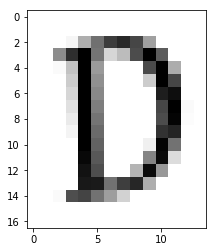

In [94]:
img = cv2.imread(get_random_img_filepath())
plt.imshow(img)

In [95]:
img.shape

(17, 14, 3)

In [100]:
x = cv2.resize(img, (100, 100))
x.shape

(100, 100, 3)

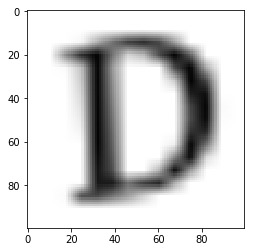

In [101]:
plt.imshow(x)

In [102]:
def show_image():
    while True:
        img_filepath = get_random_img_filepath()

        clear_output()
        display(Image(img_filepath, width = 100, height = 100))
            
        num = input('Enter c or q :: ')
        if num == 'c':
            continue
        else:
            return

In [103]:
show_image()

## ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [76]:
for folder in os.listdir('extracted letter/'):
    img_filepaths = glob.glob(os.path.join('extracted letter/' + folder, '*'))
    X, y = train_test_split(img_filepaths, test_size = 0.2, random_state = 42)
    
    for x_filepath in X:
        train_dest_folder = os.path.join('data/training/', folder)
        if not os.path.exists(train_dest_folder):
            os.mkdir(train_dest_folder)
        copy2(x_filepath, train_dest_folder)
    
    for y_filepath in y:
        test_dest_folder = os.path.join('data/validation/', folder)
        if not os.path.exists(test_dest_folder):
            os.mkdir(test_dest_folder)
        copy2(y_filepath, test_dest_folder)

## Whole Data

In [60]:
train_samples = {folder : len(os.listdir('extracted letter/' + folder)) for folder in os.listdir('extracted letter/')}
train_samples = sorted(train_samples.items(), key = lambda x : x[1])
train_samples

[('J', 1115),
 ('W', 1147),
 ('V', 1154),
 ('6', 1160),
 ('M', 1170),
 ('F', 1177),
 ('A', 1188),
 ('4', 1197),
 ('L', 1198),
 ('B', 1199),
 ('D', 1199),
 ('U', 1199),
 ('C', 1202),
 ('3', 1203),
 ('2', 1204),
 ('X', 1207),
 ('Q', 1208),
 ('8', 1214),
 ('Y', 1218),
 ('K', 1220),
 ('T', 1220),
 ('H', 1221),
 ('R', 1221),
 ('G', 1224),
 ('Z', 1226),
 ('S', 1227),
 ('5', 1231),
 ('P', 1244),
 ('N', 1249),
 ('E', 1261),
 ('7', 1284),
 ('9', 1357)]

In [63]:
total = sum([v for _, v in train_samples])
total

38744

In [64]:
print('Total data is', total)

Total data is 38744


[Text(0,0,'J'),
 Text(0,0,'W'),
 Text(0,0,'V'),
 Text(0,0,'6'),
 Text(0,0,'M'),
 Text(0,0,'F'),
 Text(0,0,'A'),
 Text(0,0,'4'),
 Text(0,0,'L'),
 Text(0,0,'B'),
 Text(0,0,'D'),
 Text(0,0,'U'),
 Text(0,0,'C'),
 Text(0,0,'3'),
 Text(0,0,'2'),
 Text(0,0,'X'),
 Text(0,0,'Q'),
 Text(0,0,'8'),
 Text(0,0,'Y'),
 Text(0,0,'K'),
 Text(0,0,'T'),
 Text(0,0,'H'),
 Text(0,0,'R'),
 Text(0,0,'G'),
 Text(0,0,'Z'),
 Text(0,0,'S'),
 Text(0,0,'5'),
 Text(0,0,'P'),
 Text(0,0,'N'),
 Text(0,0,'E'),
 Text(0,0,'7'),
 Text(0,0,'9')]

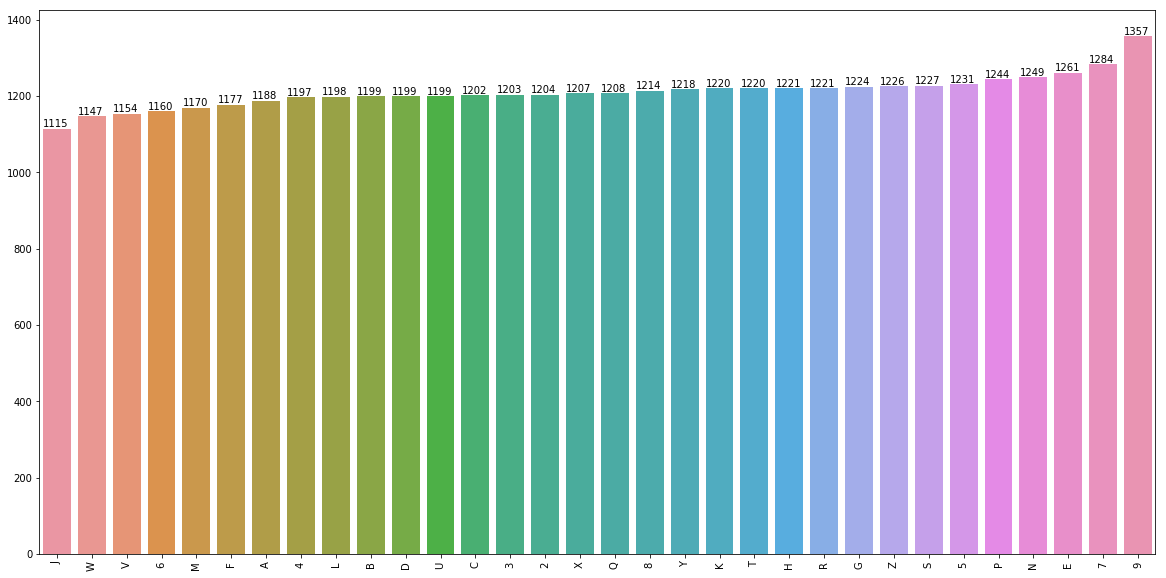

In [67]:
labels = [k for k, _ in train_samples]

fig = plt.figure(figsize= (20, 10))
ax = sns.barplot(x = labels, y = [v for _, v in train_samples])
for p in ax.patches:
    ax.annotate('{:}'.format(int(p.get_height())), (p.get_x()+0.005, p.get_height()+5.0))

ax.set_xticklabels(labels = labels, rotation = 90)

### For later do sampling to handle little to none imbalanced classes

## Training

In [77]:
training_samples = {folder : len(os.listdir('data/training/' + folder)) for folder in os.listdir('data/training/')}
training_samples = sorted(training_samples.items(), key = lambda x : x[1])
training_samples

[('J', 892),
 ('W', 917),
 ('V', 923),
 ('6', 928),
 ('M', 936),
 ('F', 941),
 ('A', 950),
 ('4', 957),
 ('L', 958),
 ('B', 959),
 ('D', 959),
 ('U', 959),
 ('C', 961),
 ('3', 962),
 ('2', 963),
 ('X', 965),
 ('Q', 966),
 ('8', 971),
 ('Y', 974),
 ('H', 976),
 ('K', 976),
 ('R', 976),
 ('T', 976),
 ('G', 979),
 ('Z', 980),
 ('S', 981),
 ('5', 984),
 ('P', 995),
 ('N', 999),
 ('E', 1008),
 ('7', 1027),
 ('9', 1085)]

In [78]:
total = sum([v for _, v in training_samples])
total

30983

In [81]:
print('Total training data is', total)

Total training data is 30983


[Text(0,0,'J'),
 Text(0,0,'W'),
 Text(0,0,'V'),
 Text(0,0,'6'),
 Text(0,0,'M'),
 Text(0,0,'F'),
 Text(0,0,'A'),
 Text(0,0,'4'),
 Text(0,0,'L'),
 Text(0,0,'B'),
 Text(0,0,'D'),
 Text(0,0,'U'),
 Text(0,0,'C'),
 Text(0,0,'3'),
 Text(0,0,'2'),
 Text(0,0,'X'),
 Text(0,0,'Q'),
 Text(0,0,'8'),
 Text(0,0,'Y'),
 Text(0,0,'H'),
 Text(0,0,'K'),
 Text(0,0,'R'),
 Text(0,0,'T'),
 Text(0,0,'G'),
 Text(0,0,'Z'),
 Text(0,0,'S'),
 Text(0,0,'5'),
 Text(0,0,'P'),
 Text(0,0,'N'),
 Text(0,0,'E'),
 Text(0,0,'7'),
 Text(0,0,'9')]

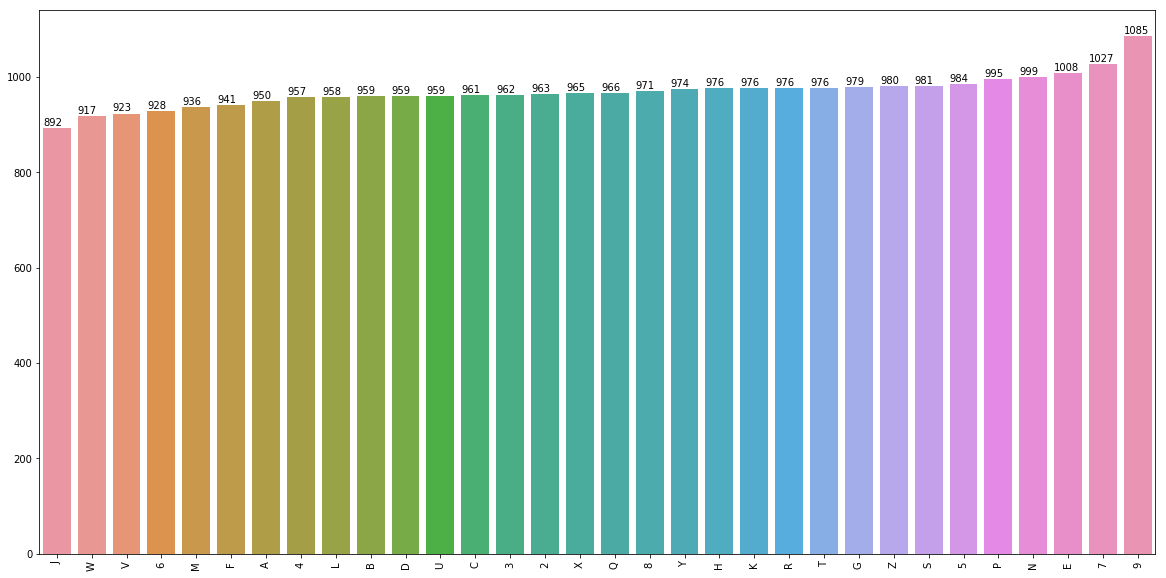

In [80]:
labels = [k for k, _ in training_samples]

fig = plt.figure(figsize= (20, 10))
ax = sns.barplot(x = labels, y = [v for _, v in training_samples])
for p in ax.patches:
    ax.annotate('{:}'.format(int(p.get_height())), (p.get_x()+0.005, p.get_height()+5.0))

ax.set_xticklabels(labels = labels, rotation = 90)

## Testing

In [82]:
testing_samples = {folder : len(os.listdir('data/validation/' + folder)) for folder in os.listdir('data/validation/')}
testing_samples = sorted(testing_samples.items(), key = lambda x : x[1])
testing_samples

[('J', 223),
 ('W', 230),
 ('V', 231),
 ('6', 232),
 ('M', 234),
 ('F', 236),
 ('A', 238),
 ('4', 240),
 ('B', 240),
 ('D', 240),
 ('L', 240),
 ('U', 240),
 ('2', 241),
 ('3', 241),
 ('C', 241),
 ('Q', 242),
 ('X', 242),
 ('8', 243),
 ('K', 244),
 ('T', 244),
 ('Y', 244),
 ('G', 245),
 ('H', 245),
 ('R', 245),
 ('S', 246),
 ('Z', 246),
 ('5', 247),
 ('P', 249),
 ('N', 250),
 ('E', 253),
 ('7', 257),
 ('9', 272)]

In [83]:
total = sum([v for _, v in testing_samples])
total

7761

In [84]:
print('Total validation data is', total)

Total validation data is 7761


[Text(0,0,'J'),
 Text(0,0,'W'),
 Text(0,0,'V'),
 Text(0,0,'6'),
 Text(0,0,'M'),
 Text(0,0,'F'),
 Text(0,0,'A'),
 Text(0,0,'4'),
 Text(0,0,'B'),
 Text(0,0,'D'),
 Text(0,0,'L'),
 Text(0,0,'U'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'C'),
 Text(0,0,'Q'),
 Text(0,0,'X'),
 Text(0,0,'8'),
 Text(0,0,'K'),
 Text(0,0,'T'),
 Text(0,0,'Y'),
 Text(0,0,'G'),
 Text(0,0,'H'),
 Text(0,0,'R'),
 Text(0,0,'S'),
 Text(0,0,'Z'),
 Text(0,0,'5'),
 Text(0,0,'P'),
 Text(0,0,'N'),
 Text(0,0,'E'),
 Text(0,0,'7'),
 Text(0,0,'9')]

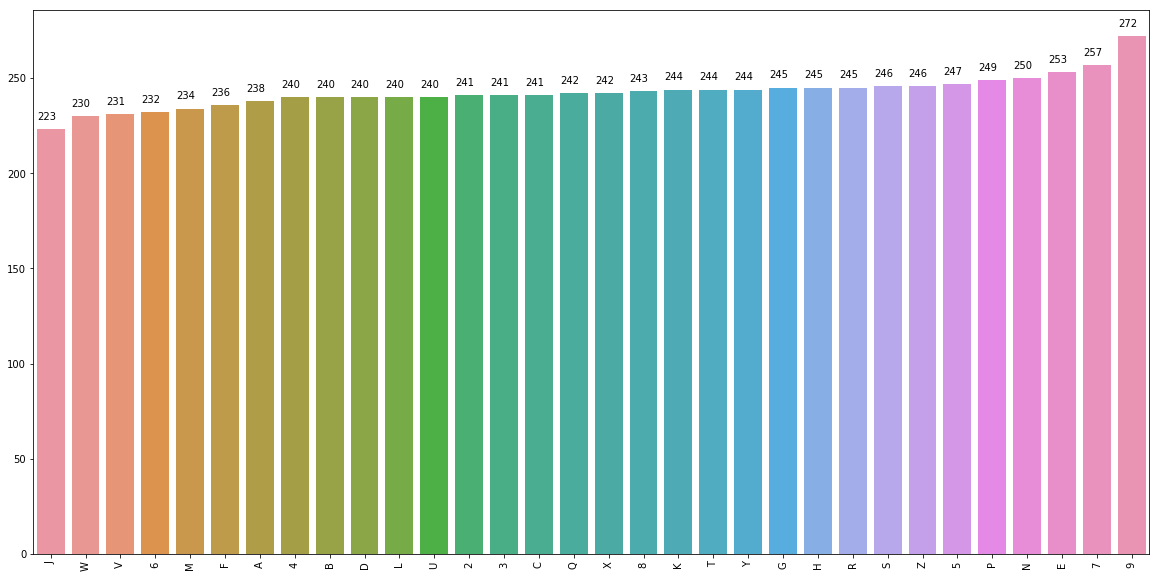

In [85]:
labels = [k for k, _ in testing_samples]

fig = plt.figure(figsize= (20, 10))
ax = sns.barplot(x = labels, y = [v for _, v in testing_samples])
for p in ax.patches:
    ax.annotate('{:}'.format(int(p.get_height())), (p.get_x()+0.005, p.get_height()+5.0))

ax.set_xticklabels(labels = labels, rotation = 90)

## ----------------------------------------------------------------------------------------------------------------------------------------------------------------

## TRAINING

In [58]:
print('Keras is using', K.backend(), 'as backend')

Keras is using tensorflow as backend


In [132]:
top_categorical_model_wt = '.'
finetuned_categorical_model_wt = '.'

img_height = 100
img_width = 100

num_classes = len(os.listdir(train_data_dir))

train_data_dir = 'data/training/'
val_data_dir = 'data/validation/'

train_samples = [len(os.listdir('data/training/' + folder)) for folder in os.listdir('data/training/')]
val_samples = [len(os.listdir('data/validation/' + folder)) for folder in os.listdir('data/validation/')]

nb_train_samples = sum(train_samples)
nb_val_samples = sum(val_samples)

epochs = 50

In [92]:
if K.image_data_format() == 'channels_last':
    input_shape = (img_height, img_width, 3)
else:
    input_shape = (3, img_height, img_width)

In [104]:
input_shape

(100, 100, 3)

In [160]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [161]:
for layer in base_model.layers:
    layer.trainable = False

In [162]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [183]:
def save_bottleneck_features(force = False):
    datagen = ImageDataGenerator(preprocess_input)
    
    if os.path.exists('bottleneck_features_train.npy') and not force:
        print('bottleneck_features_train.npy already exists')
    else:
        train_data_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size = (img_height, img_width),
            batch_size = 64,
            class_mode = None,
            shuffle = False
        )
        
        train_bottleneck_features = base_model.predict_generator(
            train_data_generator,
            steps = nb_train_samples / 64,
            workers = -1,
            use_multiprocessing = True,
            verbose = 1,
        )
        
        print('Saving bottleneck_features_train.npy')
        np.save(open('bottleneck_features_train.npy', 'wb'), train_bottleneck_features)
    
    if os.path.exists('bottleneck_features_val.npy') and not force:
        print('bottleneck_features_val.npy already exists')
    else:
        val_data_generator = datagen.flow_from_directory(
            val_data_dir,
            target_size = (img_height, img_width),
            batch_size = 64,
            class_mode = None,
            shuffle = False
        )
        
        val_bottleneck_features = base_model.predict_generator(
            val_data_generator,
            steps = nb_val_samples / 64,
            workers = -1,
            use_multiprocessing = True,
            verbose = 1,
        )
        
        print('Saving bottleneck_features_val.npy')
        np.save(open('bottleneck_features_val.npy', 'wb'), val_bottleneck_features)

In [164]:
assert len(np.concatenate([[i]*train_samples[i] for i in range(len(train_samples))])) == nb_train_samples

In [165]:
assert len(np.concatenate([[i]*val_samples[i] for i in range(len(val_samples))])) == nb_val_samples

In [176]:
def train_categorical_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    val_data = np.load(open('bottleneck_features_val.npy', 'rb'))
    
    train_labels = np.concatenate([[i]*train_samples[i] for i in range(len(train_samples))])
    val_labels = np.concatenate([[i]*val_samples[i] for i in range(len(val_samples))])
    
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape = (train_data.shape[1:])))     # 8, 8, 512
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(units = num_classes, activation = 'softmax'))       
    
    model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9),    
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    checkpoint = ModelCheckpoint(
        top_categorical_model_wt,
        monitor = 'val_acc',
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = 'auto'
    )    
    
    es = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5,
        verbose = 2, 
        mode = 'auto'
    )

    fit = model.fit(
        train_data,
        train_labels,
        epochs = epochs,
        batch_size = 32,
        validation_data = (val_data,val_labels),
        callbacks = [checkpoint]
    )
    
    with open('top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [181]:
def finetune_categorical_model():
    top_model = Sequential()
    top_model.add(Flatten(input_shape = (train_data.shape[1:])))     # 8, 8, 512
    top_model.add(Dense(units = 256, activation = 'relu'))
    top_model.add(Dropout(rate = 0.1))
    top_model.add(Dense(units = 256, activation = 'relu'))
    top_model.add(Dropout(rate = 0.1))
    top_model.add(Dense(units = num_classes, activation = 'softmax'))
    
    top_model.load_weights('top_categorical_model_wt')
    
    model = Model(inputs = base_model.input, outputs = top_model(base_model.output))
    
    print(model.summary())
    
    model.compile(
        optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9),    # reduced learning rate by 1/10
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = False
    )
    
    checkpoint = ModelCheckpoint(
        filepath = finetuned_categorical_model_wt,
        monitor = 'val_acc',
        verbose = 1,
        save_best_only = True,
        save_weights_only = False,
        mode = 'auto'
    )
    
    es = EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        patience = 5,
        verbose = 2, 
        mode = 'auto'
    )
    
    # fine-tune the model
    fit = model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples/32,
        epochs = epochs,
        validation_data = test_generator,
        validation_steps = nb_val_samples/32,
        verbose = 1,
        callbacks = [checkpoint, es],
        workers = -1,
        use_multiprocessing = True
    )

    with open('ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [150]:
def print_best_model(history, best = 'val_acc'):
    best_epoch = np.argmax(history[best]) + 1
    print('epoch:', best_epoch + 1, ', val_acc:', history['val_acc'][best_epoch], ', val_loss:', history['val_loss'][best_epoch])

In [151]:
def plot_metrics(history, stop = 50):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    axes = axes.flatten()
    
    axes[0].plot(np.arange(stop), history['acc'], label='Training', color='#FF533D')
    axes[0].plot(np.arange(stop), history['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(np.arange(stop), history['val_acc'], label='Training', color='#FF533D')
    axes[1].plot(np.arange(stop), history['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    
    print("Best Model: ")
    print_best_model_results(hist)

In [152]:
def evaluate_categorical_model(model,directory,labels):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow_from_directory(directory,
                                                     target_size=(img_height,img_width),
                                                     batch_size=8,
                                                     class_mode='categorical',     # categorical for multiclass
                                                     shuffle=False)
    
    predictions = model.predict_generator(test_generator,
                                          labels=len(labels)/8)    #?
    
    pred_labels = np.argmax(predictions, axis=1)

    print()
    print(classification_report(labels, pred_labels))        #? import
    print()

    cm = confusion_matrix(labels, pred_labels)
    return cm

### Inference

In [184]:
save_bottleneck_features(force = True)

Found 30983 images belonging to 32 classes.


/home/akash/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 49/484 [==>...........................] - ETA: 1:26:07

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/akash/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-184-d32427c0230f>", line 1, in <module>
    save_bottleneck_features(force = True)
  File "<ipython-input-183-2fa7cbb488a8>", line 20, in save_bottleneck_features
    verbose = 1,
  File "/home/akash/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/akash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 2540, in predict_generator
    outs = self.predict_on_batch(x)
  File "/home/akash/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1945, in predict_on_batch
    outputs = self.predict_function(ins)
  File "/home/akash/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2482, in __call__
    **self.session_kwar

KeyboardInterrupt: 

In [177]:
top_model, top_history = train_categorical_model()

ValueError: Input arrays should have the same number of samples as target arrays. Found 1952 input samples and 7761 target samples.

In [ ]:
ft_model, ft_history = finetune_categorical_model()